<a href="https://colab.research.google.com/github/selua/Cat_vs_Dog/blob/main/Cat_vs_Dog(TL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-11-09 12:27:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.7.208, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   144MB/s    in 0.6s    

2020-11-09 12:27:29 (144 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
pretrained_model = InceptionV3(input_shape = (150,150,3),include_top=False,weights=None)

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model.load_weights(local_weights_file)

In [5]:
for layer in pretrained_model.layers:
  layer.trainable = False

In [6]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
last_layer = pretrained_model.get_layer('mixed7')
print("last layer output shape:",last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [8]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)

x = layers.Dense(1024,activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pretrained_model.input,x)

model.compile(optimizer = RMSprop(lr = 0.0001),loss = 'binary_crossentropy',metrics = ['accuracy'])

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-11-09 12:27:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.208, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   101MB/s    in 0.6s    

2020-11-09 12:27:59 (101 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import matplotlib.pyplot as plt
import zipfile as zf
import os
%matplotlib inline
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
zf_file = '/tmp/cats_and_dogs_filtered.zip'
file1 = zf.ZipFile(zf_file,'r')
file1.extractall('/tmp/')
file1.close()

In [12]:
os.listdir('/tmp/cats_and_dogs_filtered/')

['train', 'validation', 'vectorize.py']

In [13]:
train = '/tmp/cats_and_dogs_filtered/train/'
validation = '/tmp/cats_and_dogs_filtered/validation/'

In [23]:
cat_img_path = []
for img in os.listdir('/tmp/cats_and_dogs_filtered/train/cats/')[5:10]:
  cat_img_path.append(os.path.join('/tmp/cats_and_dogs_filtered/train/cats/',img))

dog_img_path = []
for img in os.listdir('/tmp/cats_and_dogs_filtered/train/dogs/')[15:20]:
  dog_img_path.append(os.path.join('/tmp/cats_and_dogs_filtered/train/dogs/',img))


img_path = cat_img_path + dog_img_path

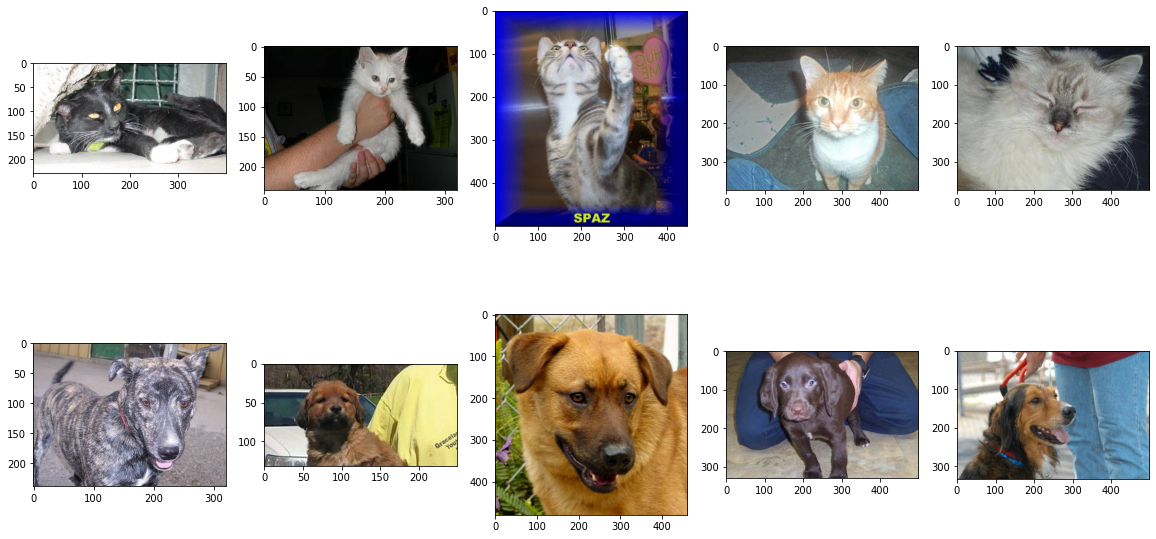

In [15]:
fig = plt.figure(figsize = (20,10))

for i, img in enumerate(img_path):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(img)
    plt.imshow(img)

In [16]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(validation,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
history = model.fit(
      train_generator,
      steps_per_epoch=63,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=32,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
63/63 - 19s - loss: 0.3348 - accuracy: 0.8855 - val_loss: 0.0861 - val_accuracy: 0.9690
Epoch 2/10
63/63 - 18s - loss: 0.1644 - accuracy: 0.9300 - val_loss: 0.0951 - val_accuracy: 0.9620
Epoch 3/10
63/63 - 18s - loss: 0.1281 - accuracy: 0.9540 - val_loss: 0.1370 - val_accuracy: 0.9520
Epoch 4/10
63/63 - 18s - loss: 0.1199 - accuracy: 0.9585 - val_loss: 0.0956 - val_accuracy: 0.9640
Epoch 5/10
63/63 - 18s - loss: 0.0847 - accuracy: 0.9670 - val_loss: 0.1605 - val_accuracy: 0.9610
Epoch 6/10
63/63 - 18s - loss: 0.0915 - accuracy: 0.9705 - val_loss: 0.1131 - val_accuracy: 0.9690
Epoch 7/10
63/63 - 18s - loss: 0.0772 - accuracy: 0.9715 - val_loss: 0.1141 - val_accuracy: 0.9720
Epoch 8/10
63/63 - 18s - loss: 0.0782 - accuracy: 0.9745 - val_loss: 0.1644 - val_accuracy: 0.9610
Epoch 9/10
63/63 - 18s - loss: 0.0608 - accuracy: 0.9815 - val_loss: 0.1334 - val_accuracy: 0.9710
Epoch 10/10
63/63 - 18s - loss: 0.0672 - accuracy: 0.9785 - val_loss: 0.1516 - val_accuracy: 0.9680


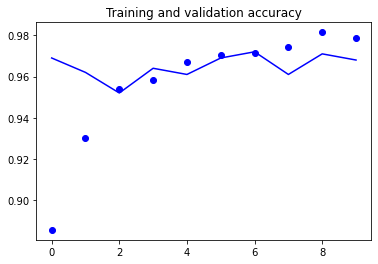

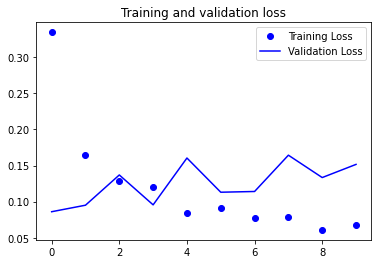

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

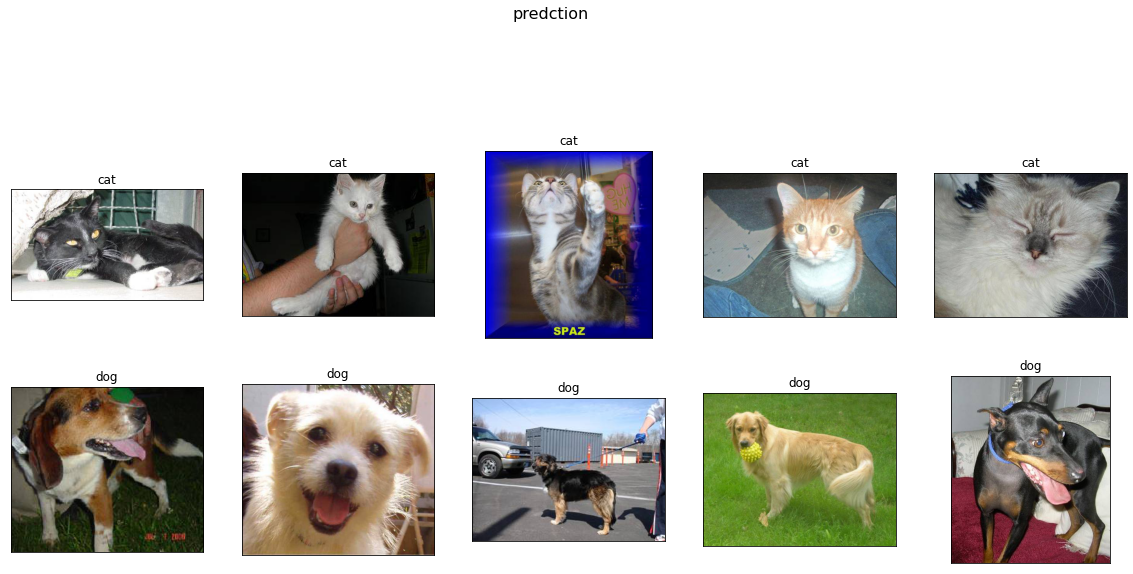

In [32]:
import numpy as np
# from google.colab import files
from tensorflow.keras.preprocessing import image

import matplotlib.image as mpimg

# upload = files.upload()

fig = plt.figure(figsize = (20,20))
fig.suptitle("predction", fontsize = 16)


for i, fn in enumerate(img_path):
    plt.subplot(5, 5, i + 1)
    img = mpimg.imread(fn)
    plt.imshow(img)
    
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    images = images/255.0

    classes = history.model.predict(images, batch_size=10)

    if classes > 0.5:
        a = "dog"
    else:
        a = "cat"
    plt.title(a)
    plt.xticks([])
    plt.yticks([])

Saving cat1.jpeg to cat1.jpeg
Saving cat2.jpeg to cat2.jpeg
Saving cat3.jpeg to cat3.jpeg
Saving dog1.jpeg to dog1.jpeg
Saving dog2.jpeg to dog2.jpeg
Saving dog3.jpeg to dog3.jpeg


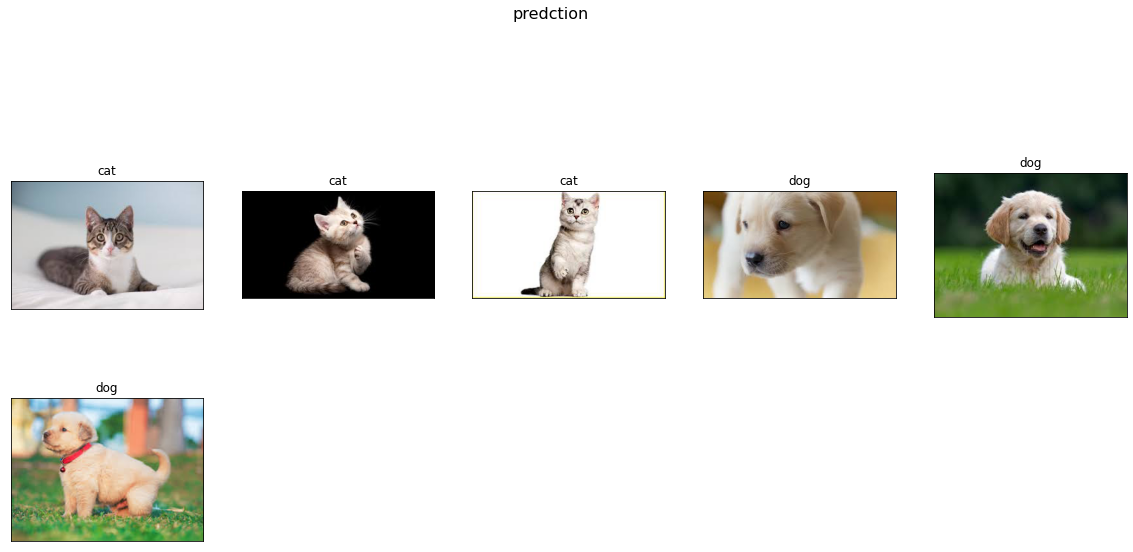

In [33]:
import numpy as np

from google.colab import files

from tensorflow.keras.preprocessing import image

import matplotlib.image as mpimg

upload = files.upload()

fig = plt.figure(figsize = (20,20))
fig.suptitle("predction", fontsize = 16)


for i, fn in enumerate(upload.keys()):
    plt.subplot(5, 5, i + 1)
    img = mpimg.imread(fn)
    plt.imshow(img)
    
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    images = images/255.0

    classes = history.model.predict(images, batch_size=10)

    if classes > 0.5:
        a = "dog"
    else:
        a = "cat"
    plt.title(a)
    plt.xticks([])
    plt.yticks([])